In [159]:
% matplotlib inline
from __future__ import (division, 
                        print_function)

import os
import sys
import copy
import fnmatch
import warnings

# Numpy & Scipy
import scipy
import numpy as np 

# Astropy related
from astropy.io import fits 
from astropy import wcs
from astropy import units as u
from astropy.table import Table, Column, vstack
from astropy.stats import sigma_clip

# Matplotlib 
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker

# from astroML.plotting import hist
# plt.ioff()

# Astro-ML/Histogram
from astroML.plotting import hist

# ColorMap
from palettable.colorbrewer.sequential import PuBu_5, OrRd_6
cmap1 = PuBu_5.mpl_colormap
cmap2 = OrRd_6.mpl_colormap

# Matplotlib default settings
rcdef = plt.rcParams.copy()
rcdef['figure.figsize'] = 12, 10
rcdef['xtick.major.size'] = 8.0
rcdef['xtick.major.width'] = 1.5
rcdef['xtick.minor.size'] = 4.0
rcdef['xtick.minor.width'] = 1.5
rcdef['ytick.major.size'] = 8.0
rcdef['ytick.major.width'] = 1.5
rcdef['ytick.minor.size'] = 4.0
rcdef['ytick.minor.width'] = 1.5
rcdef['legend.numpoints'] = 1
#rc('axes', linewidth=2)

# Shapely related imports
from shapely.geometry import Polygon, LineString, Point
from shapely          import wkb
from shapely.ops      import cascaded_union
from shapely.prepared import prep
from descartes import PolygonPatch

# Color map 
from palettable.colorbrewer.sequential import Oranges_4, Blues_5
ORG4 = Oranges_4.mpl_colormap
BLU5 = Blues_5.mpl_colormap

# Personal tools
from hscUtils import songPlotSetup, removeIsNullCol

# SDSS pivot wavelength 
sdss_u_pivot = 3551.0
sdss_g_pivot = 4686.0
sdss_r_pivot = 6165.0
sdss_i_pivot = 7481.0
sdss_z_pivot = 8931.0

# GALEX pivot wavelength 
galex_fuv_pivot = 1535.0
galex_nuv_pivot = 2301.0

# WISE pivot wavelength 
wise_w1_pivot = 34000.0
wise_w2_pivot = 46000.0

# HSC pivot wavelength 
hsc_g_pivot = 4782.2
hsc_r_pivot = 6101.7 
hsc_i_pivot = 7648.0 
hsc_z_pivot = 8883.0
hsc_y_pivot = 9750.8

hscFilters = ['g', 'r', 'i', 'z', 'y']
hscFiltWave = np.asarray([hsc_g_pivot, hsc_r_pivot, hsc_i_pivot, hsc_z_pivot, hsc_y_pivot])

# Color 
BLUE0 = "#92c5de"
BLUE1 = "#0571b0"
RED0 = "#f4a582"
RED1 = "#ca0020"
PURPLE0 = '#af8dc3'
PURPLE1 = '#762a83'
BROWN0 = '#bf812d'
BROWN1 = '#543005'
GREEN0 = '#7fbf7b'
GREEN1 = '#1b7837'

# definitions for the axes
left, width    = 0.155, 0.66
right          = left + width 
bottom, height = 0.13, 0.86
bottom_h = left_h = left + width + 0.02
recScat = [left,   bottom, width, height]
recHist = [right,  bottom,  0.18, height]

SBP1 = [0.13, 0.12, 0.865, 0.30]
SBP2 = [0.13, 0.42, 0.865, 0.54]

In [207]:
def hscFlux2AB(flux, zero=27.0): 
    """
    Convert HSC flux in unit of ADU to AB magnitude. 
    
    So far, constant zeropoint is applied to the calibration 
    """
    try: 
        mag = -2.5 * np.log10(flux) + zero
    except NameError: 
        import numpy as np 
        mag = -2.5 * np.log10(flux) + zero
    return mag

def hscMag2Flux(mag, unit='maggy'):
    """
    Convert HSC AB magnitude into physical flux. 
    
    Three units can be used here: 
    unit='maggy/nanomaggy/jy'
    """
    flux = 10.0 ** (-0.4 * mag) 
    
    if unit.lower().strip() == 'jy': 
        return (flux * 3631.0)
    elif unit.lower().strip() == 'maggy': 
        return flux 
    elif unit.lower().strip() == 'nanomaggy':
        return (flux * 1.0E-9)
    else: 
        raise Exception("## Wrong unit, should be jy/maggy/nanomaggy")
        
        
def hscMaggy2AB(flux):
    """
    Convert flux in unit of Maggies into AB magnitude
    """
    
    return (np.log10(flux) / -0.4)
        
    
def hscMaggyErr2ABErr(flux, fluxErr, ivar=False):
    """
    Convert (flux, fluxErr) into AB magnitude error 
    """
    
    if ivar: 
        fluxErr = np.sqrt(1.0 / fluxErr)
    
    return (2.5 * np.log10((flux + fluxErr) / flux))
    
    
def hscMagerr2Ivar(flux, magErr): 
    """
    Get the inverse variance of flux estimates from Flux and magErr 
    """
    
    fluxErr = flux * ((10.0 ** (magErr/2.5)) - 1.0)
    
    return (1.0 / (fluxErr ** 2.0))

def hscMagerr2Fluxerr(flux, magErr): 
    """
    Get the inverse variance of flux estimates from Flux and magErr 
    """
    
    fluxErr = flux * ((10.0 ** (magErr/2.5)) - 1.0)
    
    return fluxErr

def hscFluxSNR2Ivar(flux, snr, filt='i'): 
    """
    Estimate inverse variance of flux error using HSC flux and snr 
    """
    if filt is 'g':
        snr *= 0.9
    elif filt is 'y':
        snr *= 0.8
        
    fluxErr = flux / snr 
    
    return (1.0 / (fluxErr ** 2.0))

def polyReadWkb(wkbName, load=True):
    """Read a .wkb file into a Polygon shape."""
    wkbFile = open(wkbName, 'r')
    polyWkb = wkbFile.read().decode('hex')
    wkbFile.close()

    if load is True:
        return wkb.loads(polyWkb)
    else:
        return polyWkb
    
    
def filterCatlog(inputCat, raCol, decCol, filtUse='I', 
                 regUse='g09', reject=True, polyDir='./',
                 returnMask=True,
                 acpFormat='dr1_wide_HSC-FILTER_patch_REG.wkb',
                 rejFormat='dr1_wide_HSC-FILTER_wkbBig_REG.wkb'):
    """Filter a catalog using accept and rejection mask."""
    if not os.path.isfile(inputCat):
        raise Exception("Can not find input catalog: %s" % s)

    inputData = Table.read(inputCat, format='fits')

    raArr, decArr = inputData[raCol].data, inputData[decCol].data
    print("Will deal with %d objects" % len(raArr))

    acpStr = acpFormat.replace('FILTER', filtUse)
    acpStr = acpStr.replace('REG', regUse)
    print("Filter through the accept mask: %s" % acpStr)
    acpMask = os.path.join(polyDir, acpStr)
    if not os.path.isfile(acpMask):
        raise Exception("Can not find accept mask: %s" % acpMask)
    acpRegs = polyReadWkb(acpMask)
    acpPrep = prep(acpRegs)
    inside = map(lambda x, y: acpPrep.contains(Point(x, y)), raArr, decArr)

    if reject:
        rejStr = rejFormat.replace('FILTER', filtUse)
        rejStr = rejStr.replace('REG', regUse)
        print("Filter through the reject mask: %s" % rejStr)
        rejMask = os.path.join(polyDir, rejStr)
        if not os.path.isfile(rejMask):
            raise Exception("Can not find reject mask: %s" % rejMask)
        rejRegs = polyReadWkb(rejMask)
        rejPrep = prep(rejRegs)
        masked = map(lambda x, y: rejPrep.contains(Point(x, y)), raArr, decArr)
        
        useful = map(lambda x, y: x and (not y), inside, masked)
    else:
        useful = inside
    
    if returnMask:
        return inputData[np.where(useful)], acpRegs, rejRegs
    else:
        return inputData[np.where(useful)]
    

def showPolyMask(maskShow, ax, color='k', alpha=0.6, lw=1.5):
    """Outline all the mask regions."""
    if maskShow.type is "Polygon":
        bounds = maskShow.boundary
        if bounds.type is "LineString":
            x, y = bounds.xy
            ax.plot(x, y, c=color, lw=lw, alpha=alpha)
        elif bounds.type is "MultiLineString":
            for bb in bounds:
                x, y = bb.xy
                ax.plot(x, y, c=color, lw=lw, alpha=alpha)
    elif maskShow.type is "MultiPolygon":
        for ii, mask in enumerate(maskShow):
            bounds = mask.boundary
            if bounds.type is "LineString":
                x, y = bounds.xy
                ax.plot(x, y, c=color, lw=lw, alpha=alpha)
            elif bounds.type is "MultiLineString":
                for bb in bounds:
                    x, y = bb.xy
                    ax.plot(x, y, c=color, lw=lw, alpha=alpha)
            else:
                print(" !!! Can not plot shape %d - %s !" % (ii, bounds.type))
                
                
def addMaggies(inputCat, magType='mag_cmodel', 
               snr=None, 
               filters=['g', 'r', 'i', 'z', 'y'],
               maggiesCol='cmodel_maggies', ivarsCol='cmodel_ivars',
               saveNew=True, outputCat=None, sortCol=None):
    """Convert the magnitude and error into Maggies and IvarMaggies."""
    if not os.path.isfile(inputCat):
        raise Exception("Can not find input catalog: %s" % s)
    
    data = Table.read(inputCat, format='fits')
    
    maggies = np.dstack((map(lambda f: hscMag2Flux(data[f + magType] - 
                                                   data['a_' + f], unit='maggy'), filters)))[0]

    if snr is None:
        ivars = np.dstack((map(lambda f: hscMagerr2Ivar(
                        hscMag2Flux(data[f + magType] - data['a_' + f], unit='maggy'), 
                        data[f + magType + '_err']), filters)))[0]
    else:
        ivars = np.dstack((map(lambda f: hscFluxSNR2Ivar(
                        hscMag2Flux(data[f + magType] - data['a_' + f], unit='maggy'), 
                        snr, filt=f), filters)))[0]
        
    data.add_column(Column(name=maggiesCol, data=maggies))
    data.add_column(Column(name=ivarsCol, data=ivars))
                    
    if sortCol is not None:
        data.sort(sortCol)
                    
    if saveNew:
        if outputCat is None: 
            newCat = inputCat.replace('.fits', '_' + magType + '_maggies.fits')
        else:
            newCat = outputCat
        
        data.write(newCat, format='fits', overwrite=True)

    return data


def simpleScatter(xarr, yarr, 
                  xtick=True, ytick=True,
                  xstr=None, ystr=None, titleUse=None, 
                  carr=None, sarr=None, 
                  cmap=ORG4, maxSize=350, alpha=0.8, 
                  ax=None, xylim=True, nolabel=False, 
                  titleSize=20, labelSize=36, 
                  titleX=0.04, titleY=0.92, 
                  xmargin=7.5, ymargin=7.5, 
                  noEdge=True, colorUse='k', sizeUse=40,
                  label=None):
    #---------------------------------------------------------#
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
        ax1 = fig.add_subplot(111)
    else:
        ax1 = ax

    # Formatting 
        ax1 = songPlotSetup(ax1)
        
    # Color Array 
    if carr is None:
        carr = colorUse
    else:
        carr = toColorArr(carr)
      
    # Size Array
    if sarr is None: 
        sarr = sizeUse
    else: 
        sarr = toSizeArr(sarr, maxSize=maxSize)
    
    # Scatter plot
    if noEdge:
        ax1.scatter(xarr, yarr, c=carr, s=sarr, 
                    alpha=alpha, cmap=cmap, 
                    edgecolor='none', label=label)
    else:
        ax1.scatter(xarr, yarr, c=carr, s=sarr, 
                    alpha=alpha, cmap=cmap, label=label)

    # Label
    if xstr is not None:
        ax1.set_xlabel(xstr, size=labelSize)
    if ystr is not None:
        ax1.set_ylabel(ystr, size=labelSize)

    # Axis limits
    if xylim:
        xmin, xmax = np.nanmin(xarr), np.nanmax(xarr)
        ymin, ymax = np.nanmin(yarr), np.nanmax(yarr)
        xmargin, ymargin = ((xmax - xmin) / xmargin), ((ymax - ymin) / ymargin)
        ax1.set_xlim(xmin-xmargin, xmax+xmargin)
        ax1.set_ylim(ymin-ymargin, ymax+ymargin)

    # Title 
    if titleUse is not None:
        titleUse = titleUse.replace('_', '\_')
        ax1.text(titleX, titleY, '$\mathrm{%s}$' % titleUse, size=titleSize, 
                 transform = ax1.transAxes)
    #---------------------------------------------------------#
    if ax is None:
        return fig
    else: 
        return ax1
    

def qualityControl(inputTab, useY=True, strict=False, verbose=True):
    """HSC basic quality"""
    table = copy.deepcopy(inputTab)
    nGal = len(table)
    
    outputTab = table[(table['ir_merge_peak_g']) &
                      (table['ir_merge_peak_r']) &
                      (table['ir_merge_peak_z']) &
                      (table['ir_merge_peak_y']) &
                      (~table['if_shape_sdss_flags']) & 
                      (~table['ir_deblend_as_psf']) &
                      (~table['gf_flags_pixel_edge']) &
                      (~table['rf_flags_pixel_edge']) &
                      (~table['if_flags_pixel_edge']) &
                      (~table['zf_flags_pixel_edge']) &
                      (~table['gf_cmodel_flux_flags']) &
                      (~table['rf_cmodel_flux_flags']) &
                      (~table['zf_cmodel_flux_flags']) &
                      (~table['gf_centroid_sdss_flags']) &
                      (~table['rf_centroid_sdss_flags']) &
                      (~table['zf_centroid_sdss_flags']) &
                      (~table['gf_flags_pixel_suspect_center']) &
                      (~table['rf_flags_pixel_suspect_center']) &
                      (~table['if_flags_pixel_suspect_center']) &
                      (~table['zf_flags_pixel_suspect_center']) &
                      (~table['gf_flags_pixel_saturated_center']) &
                      (~table['rf_flags_pixel_saturated_center']) &
                      (~table['zf_flags_pixel_saturated_center']) &
                      (~table['gf_flags_pixel_interpolated_center']) &
                      (~table['rf_flags_pixel_interpolated_center']) &
                      (~table['zf_flags_pixel_interpolated_center'])
                     ]
    
    if useY: 
        outputTab = outputTab[(np.isfinite(outputTab['ymag_cmodel'])) &
                              (~outputTab['yf_flags_pixel_edge']) &
                              (~outputTab['yf_centroid_sdss_flags']) &
                              (~outputTab['yf_cmodel_flux_flags']) &
                              (~outputTab['yf_flags_pixel_suspect_center']) &
                              (~outputTab['yf_flags_pixel_saturated_center']) &
                              (~outputTab['yf_flags_pixel_interpolated_center'])
                             ]

    if strict:
        outputTab = outputTab[(~outputTab['gf_flags_pixel_clipped_any']) &
                              (~outputTab['rf_flags_pixel_clipped_any']) &
                              (~outputTab['zf_flags_pixel_clipped_any'])
                             ]
    
    if verbose:
        print("# %d / %d items left in the sample" % (len(outputTab), nGal))
    
    return outputTab 

# Selection of massive galaxies from the HSC S15B data release 

## Location of the master catalogs

In [206]:
# Working directory 
dataDir = '/Users/songhuang/Downloads/dr15b'

# Spec-z catalog 
speczCat = os.path.join(dataDir, 'basic/specz/dr1_specz_use.fits')

# Location for the galaxy catalogs
galDir = os.path.join(dataDir, 'wide_galaxy')
galWideOri = 'dr1_gal21_cmodel_i.fits'
galWide = 'dr1_hsc_gal21_master.fits'

# Location for the basic geometry of coadd data
mosaicDir = os.path.join(dataDir, 'basic/mosaic')
mosaicPre = 's15b_wide_i_mosaic_REG.fits'

# polyMask of this data release
polyDir = os.path.join(dataDir, 'basic/polymask/wide')
acpFormat = 'dr1_wide_HSC-FILTER_patch_REG.wkb'
rejFormat = 'dr1_wide_HSC-FILTER_wkbBig_REG.wkb'

# Wide fields used: 
## GAMA09;  GAMA15;  WIDE12;  XMM-LSS;  HECTOMAP;  VVDS
fields = ['g09', 'g15', 'w12', 'xmm', 'hec', 'vvd']
filters = ['G', 'R', 'I', 'Z', 'Y']

# SDSS Master
sdssMaster = os.path.join(dataDir, 'sdss', 'sdss_dr12_i20.5_master.fits')
# GAMA Master 
gamaMaster = os.path.join(dataDir, 'gama', 'gama_dr2_master.fits')
# redMaPPer Master
redbcgMaster = os.path.join(dataDir, 'redmapper', 'redmapper_dr8_bcg_master.fits')
redmemMaster = os.path.join(dataDir, 'redmapper', 'redmapper_dr8_mem_master.fits')
redmemUse = os.path.join(dataDir, 'redmapper', 'dr1_redmem_use.fits')

## Remove the IS_NULL columns, and show the colnames

In [40]:
# Galaxies in the WIDE
galWideData = Table.read(os.path.join(galDir, galWide), format='fits')
print(galWideData.colnames)

['ra_hsc', 'dec_hsc', 'gallon', 'gallat', 'tract', 'patch', 'id', 'parent', 'a_g', 'a_r', 'a_i', 'a_z', 'a_y', 'gmag_psf', 'gmag_psf_err', 'rmag_psf', 'rmag_psf_err', 'imag_psf', 'imag_psf_err', 'zmag_psf', 'zmag_psf_err', 'ymag_psf', 'ymag_psf_err', 'gmag_kron', 'gmag_kron_err', 'rmag_kron', 'rmag_kron_err', 'imag_kron', 'imag_kron_err', 'zmag_kron', 'zmag_kron_err', 'ymag_kron', 'ymag_kron_err', 'gmag_cmodel', 'gmag_cmodel_err', 'gmag_cmodel_exp', 'gmag_cmodel_exp_err', 'gmag_cmodel_dev', 'gmag_cmodel_dev_err', 'rmag_cmodel', 'rmag_cmodel_err', 'rmag_cmodel_exp', 'rmag_cmodel_exp_err', 'rmag_cmodel_dev', 'rmag_cmodel_dev_err', 'imag_cmodel', 'imag_cmodel_err', 'imag_cmodel_exp', 'imag_cmodel_exp_err', 'imag_cmodel_dev', 'imag_cmodel_dev_err', 'zmag_cmodel', 'zmag_cmodel_err', 'zmag_cmodel_exp', 'zmag_cmodel_exp_err', 'zmag_cmodel_dev', 'zmag_cmodel_dev_err', 'ymag_cmodel', 'ymag_cmodel_err', 'ymag_cmodel_exp', 'ymag_cmodel_exp_err', 'ymag_cmodel_dev', 'ymag_cmodel_dev_err', 'gflux_ps

In [16]:
# Spec-Z catalogs
speczData = Table.read(speczCat, format='fits')
print(speczData.colnames)

['specz_id', 'specz_name', 'specz_ra', 'specz_dec', 'z_hsc', 'z_hsc_err']


## redBCG catalogs

In [42]:
inputCat = redbcgMaster 
raCol, decCol = 'ra_bcg_redm', 'dec_bcg_redm'

### GAMA09 : dr1_redbcg_g09.fits

In [46]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'g09'

# Filter the input catalog:
redbcgG09, acpG09, rejG09 = filterCatlog(inputCat, raCol, decCol, 
                                         filtUse=filtUse, regUse=regUse,
                                         reject=True, polyDir=polyDir)
print("# %d matches" % len(redbcgG09))
# Save the catalog:
redbcgG09.write(os.path.join(dataDir, 'redmapper', 'dr1_redbcg_g09.fits'),
                format='fits', overwrite=True)

Will deal with 26350 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_g09.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_g09.wkb
# 222 matches


### GAMA15: dr1_redbcg_g15.fits

In [47]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'g15'

# Filter the input catalog:
redbcgG15, acpG15, rejG15 = filterCatlog(inputCat, raCol, decCol, 
                                         filtUse=filtUse, regUse=regUse,
                                         reject=True, polyDir=polyDir)
print("# %d matches" % len(redbcgG15))
# Save the catalog:
redbcgG15.write(os.path.join(dataDir, 'redmapper', 'dr1_redbcg_g15.fits'),
                format='fits', overwrite=True)

Will deal with 26350 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_g15.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_g15.wkb
# 98 matches


### WIDE12: dr1_redbcg_w12.fits

In [48]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'w12'

# Filter the input catalog:
redbcgW12, acpW12, rejW12 = filterCatlog(inputCat, raCol, decCol, 
                                         filtUse=filtUse, regUse=regUse,
                                         reject=True, polyDir=polyDir)
print("# %d matches" % len(redbcgW12))
# Save the catalog:
redbcgW12.write(os.path.join(dataDir, 'redmapper', 'dr1_redbcg_w12.fits'),
                format='fits', overwrite=True)

Will deal with 26350 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_w12.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_w12.wkb
# 104 matches


### VVDS: dr1_redbcg_vvd.fits

In [49]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'vvd'

# Filter the input catalog:
redbcgVVD, acpVVD, rejVVD = filterCatlog(inputCat, raCol, decCol, 
                                         filtUse=filtUse, regUse=regUse,
                                         reject=True, polyDir=polyDir)
print("# %d matches" % len(redbcgVVD))
# Save the catalog:
redbcgVVD.write(os.path.join(dataDir, 'redmapper', 'dr1_redbcg_vvd.fits'),
                format='fits', overwrite=True)

Will deal with 26350 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_vvd.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_vvd.wkb
# 188 matches


### XMM-LSS: dr1_redbcg_xmm.fits

In [50]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'xmm'

# Filter the input catalog:
redbcgXMM, acpXMM, rejXMM = filterCatlog(inputCat, raCol, decCol, 
                                         filtUse=filtUse, regUse=regUse,
                                         reject=True, polyDir=polyDir)
print("# %d matches" % len(redbcgXMM))
# Save the catalog:
redbcgXMM.write(os.path.join(dataDir, 'redmapper', 'dr1_redbcg_xmm.fits'),
                format='fits', overwrite=True)

Will deal with 26350 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_xmm.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_xmm.wkb
# 139 matches


### HectoMap: dr1_redbcg_hec.fits

In [51]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'hec'

# Filter the input catalog:
redbcgHEC, acpHEC, rejHEC = filterCatlog(inputCat, raCol, decCol, 
                                         filtUse=filtUse, regUse=regUse,
                                         reject=True, polyDir=polyDir)
print("# %d matches" % len(redbcgHEC))
# Save the catalog:
redbcgHEC.write(os.path.join(dataDir, 'redmapper', 'dr1_redbcg_hec.fits'),
                format='fits', overwrite=True)

Will deal with 26350 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_hec.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_hec.wkb
# 25 matches


## redMem catalogs

In [72]:
inputCat = redmemUse
raCol, decCol = 'ra_mem_redm', 'dec_mem_redm'

### GAMA09: dr1_redmem_g09.fits

In [73]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'g09'

# Filter the input catalog:
redmemG09 = filterCatlog(inputCat, raCol, decCol, 
                         filtUse=filtUse, regUse=regUse,
                         reject=True, polyDir=polyDir, returnMask=False)
print("# %d matches" % len(redmemG09))
# Save the catalog:
redmemG09.write(os.path.join(dataDir, 'redmapper', 'dr1_redmem_g09.fits'),
                format='fits', overwrite=True)

Will deal with 50753 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_g09.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_g09.wkb
# 14950 matches


### GAMA15: dr1_redmem_g15.fits

In [74]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'g15'

# Filter the input catalog:
redmemG15 = filterCatlog(inputCat, raCol, decCol, 
                         filtUse=filtUse, regUse=regUse,
                         reject=True, polyDir=polyDir, returnMask=False)
print("# %d matches" % len(redmemG15))
# Save the catalog:
redmemG15.write(os.path.join(dataDir, 'redmapper', 'dr1_redmem_g15.fits'),
                format='fits', overwrite=True)

Will deal with 50753 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_g15.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_g15.wkb
# 6265 matches


### WIDE12: dr1_redmem_w12.fits

In [75]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'w12'

# Filter the input catalog:
redmemW12 = filterCatlog(inputCat, raCol, decCol, 
                         filtUse=filtUse, regUse=regUse,
                         reject=True, polyDir=polyDir, returnMask=False)
print("# %d matches" % len(redmemW12))
# Save the catalog:
redmemW12.write(os.path.join(dataDir, 'redmapper', 'dr1_redmem_w12.fits'),
                format='fits', overwrite=True)

Will deal with 50753 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_w12.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_w12.wkb
# 6425 matches


### VVDS: dr1_redmem_vvd.fits

In [76]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'vvd'

# Filter the input catalog:
redmemVVD = filterCatlog(inputCat, raCol, decCol, 
                         filtUse=filtUse, regUse=regUse,
                         reject=True, polyDir=polyDir, returnMask=False)
print("# %d matches" % len(redmemVVD))
# Save the catalog:
redmemVVD.write(os.path.join(dataDir, 'redmapper', 'dr1_redmem_vvd.fits'),
                format='fits', overwrite=True)

Will deal with 50753 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_vvd.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_vvd.wkb
# 12110 matches


### XMM-LSS: dr1_redmem_xmm.fits

In [77]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'xmm'

# Filter the input catalog:
redmemXMM = filterCatlog(inputCat, raCol, decCol, 
                         filtUse=filtUse, regUse=regUse,
                         reject=True, polyDir=polyDir, returnMask=False)
print("# %d matches" % len(redmemXMM))
# Save the catalog:
redmemXMM.write(os.path.join(dataDir, 'redmapper', 'dr1_redmem_xmm.fits'),
                format='fits', overwrite=True)

Will deal with 50753 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_xmm.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_xmm.wkb
# 8427 matches


### HectoMap: dr1_redmem_hec.fits

In [78]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'hec'

# Filter the input catalog:
redmemHEC = filterCatlog(inputCat, raCol, decCol, 
                         filtUse=filtUse, regUse=regUse,
                         reject=True, polyDir=polyDir, returnMask=False)
print("# %d matches" % len(redmemHEC))
# Save the catalog:
redmemHEC.write(os.path.join(dataDir, 'redmapper', 'dr1_redmem_hec.fits'),
                format='fits', overwrite=True)

Will deal with 50753 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_hec.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_hec.wkb
# 1391 matches


## GAMA catalogs

In [52]:
inputCat = gamaMaster 
raCol, decCol = 'ra_gama', 'dec_gama'

### GAMA 09: dr1_gama_g09.fits

In [53]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'g09'

# Filter the input catalog:
gamaG09 = filterCatlog(inputCat, raCol, decCol, filtUse=filtUse, regUse=regUse,
                       reject=True, polyDir=polyDir, returnMask=False)
print("# %d matches" % len(gamaG09))
# Save the catalog:
gamaG09.write(os.path.join(dataDir, 'gama', 'dr1_gama_g09.fits'),
              format='fits', overwrite=True)

Will deal with 70726 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_g09.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_g09.wkb
# 17603 matches


### GAMA 15: dr1_gama_g15.fits

In [54]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'g15'

# Filter the input catalog:
gamaG15 = filterCatlog(inputCat, raCol, decCol, filtUse=filtUse, regUse=regUse,
                       reject=True, polyDir=polyDir, returnMask=False)
print("# %d matches" % len(gamaG15))
# Save the catalog:
gamaG15.write(os.path.join(dataDir, 'gama', 'dr1_gama_g15.fits'),
              format='fits', overwrite=True)

Will deal with 70726 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_g15.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_g15.wkb
# 20954 matches


### GAMA 12: dr1_gama_w12.fits

In [55]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'w12'

# Filter the input catalog:
gamaW12 = filterCatlog(inputCat, raCol, decCol, filtUse=filtUse, regUse=regUse,
                       reject=True, polyDir=polyDir, returnMask=False)
print("# %d matches" % len(gamaW12))
# Save the catalog:
gamaW12.write(os.path.join(dataDir, 'gama', 'dr1_gama_w12.fits'),
              format='fits', overwrite=True)

Will deal with 70726 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_w12.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_w12.wkb
# 13432 matches


## SDSS catalogs

In [56]:
inputCat = sdssMaster 
raCol, decCol = 'ra_sdss', 'dec_sdss'

### G09: dr1_sdss_g09.fits

In [57]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'g09'

# Filter the input catalog:
sdssG09 = filterCatlog(inputCat, raCol, decCol, filtUse=filtUse, regUse=regUse,
                       reject=True, polyDir=polyDir, returnMask=False)
print("# %d matches" % len(sdssG09))
# Save the catalog:
sdssG09.write(os.path.join(dataDir, 'sdss', 'dr1_sdss_g09.fits'),
              format='fits', overwrite=True)

Will deal with 1015171 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_g09.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_g09.wkb
# 200304 matches


### G15: dr1_sdss_g15.fits

In [58]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'g15'

# Filter the input catalog:
sdssG15 = filterCatlog(inputCat, raCol, decCol, filtUse=filtUse, regUse=regUse,
                       reject=True, polyDir=polyDir, returnMask=False)
print("# %d matches" % len(sdssG15))
# Save the catalog:
sdssG15.write(os.path.join(dataDir, 'sdss', 'dr1_sdss_g15.fits'),
              format='fits', overwrite=True)

Will deal with 1015171 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_g15.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_g15.wkb
# 111248 matches


### W12: dr1_sdss_w12.fits

In [59]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'w12'

# Filter the input catalog:
sdssW12 = filterCatlog(inputCat, raCol, decCol, filtUse=filtUse, regUse=regUse,
                       reject=True, polyDir=polyDir, returnMask=False)
print("# %d matches" % len(sdssW12))
# Save the catalog:
sdssW12.write(os.path.join(dataDir, 'sdss', 'dr1_sdss_w12.fits'),
              format='fits', overwrite=True)

Will deal with 1015171 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_w12.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_w12.wkb
# 111156 matches


### VVD: dr1_sdss_vvd.fits

In [61]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'vvd'

# Filter the input catalog:
sdssVVD = filterCatlog(inputCat, raCol, decCol, filtUse=filtUse, regUse=regUse,
                       reject=True, polyDir=polyDir, returnMask=False)
print("# %d matches" % len(sdssVVD))
# Save the catalog:
sdssVVD.write(os.path.join(dataDir, 'sdss', 'dr1_sdss_vvd.fits'),
              format='fits', overwrite=True)

Will deal with 1015171 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_vvd.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_vvd.wkb
# 172156 matches


### XMM: dr1_sdss_xmm.fits

In [62]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'xmm'

# Filter the input catalog:
sdssXMM = filterCatlog(inputCat, raCol, decCol, filtUse=filtUse, regUse=regUse,
                       reject=True, polyDir=polyDir, returnMask=False)
print("# %d matches" % len(sdssXMM))
# Save the catalog:
sdssXMM.write(os.path.join(dataDir, 'sdss', 'dr1_sdss_xmm.fits'),
              format='fits', overwrite=True)

Will deal with 1015171 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_xmm.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_xmm.wkb
# 161847 matches


### HEC: dr1_sdss_hec.fits

In [64]:
# ------------------------------------------------------------------------------#
filtUse, regUse = 'I', 'hec'

# Filter the input catalog:
sdssHEC = filterCatlog(inputCat, raCol, decCol, filtUse=filtUse, regUse=regUse,
                       reject=True, polyDir=polyDir, returnMask=False)
print("# %d matches" % len(sdssHEC))
# Save the catalog:
sdssHEC.write(os.path.join(dataDir, 'sdss', 'dr1_sdss_hec.fits'),
              format='fits', overwrite=True)

Will deal with 1015171 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_hec.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_hec.wkb
# 30660 matches


## Combine catalogs 

### redMapper BCG catalogs

In [68]:
redbcgAll = vstack([redbcgG09, redbcgG15, redbcgW12, 
                    redbcgVVD, redbcgXMM, redbcgHEC])

print("# %d matches" % len(redbcgAll))
# Save the catalog:
redbcgAll.write(os.path.join(dataDir, 'redmapper', 'dr1_redbcg_filtered.fits'),
                format='fits', overwrite=True)

# 776 matches


### redMapper Member catalogs

In [79]:
redmemAll = vstack([redmemG09, redmemG15, redmemW12, 
                    redmemVVD, redmemXMM, redmemHEC])

print("# %d matches" % len(redmemAll))
# Save the catalog:
redmemAll.write(os.path.join(dataDir, 'redmapper', 'dr1_redmem_filtered.fits'),
                format='fits', overwrite=True)

# 49568 matches


### GAMA spec-z catalogs

In [69]:
gamaAll = vstack([gamaG09, gamaG15, gamaW12])

print("# %d matches" % len(gamaAll))
# Save the catalog:
gamaAll.write(os.path.join(dataDir, 'gama', 'dr1_gama_filtered.fits'),
              format='fits', overwrite=True)

# 51989 matches


### SDSS photometric + spec-z catalogs

In [70]:
sdssAll = vstack([sdssG09, sdssG15, sdssW12, 
                  sdssVVD, sdssXMM, sdssHEC])

print("# %d matches" % len(sdssAll))
# Save the catalog:
sdssAll.write(os.path.join(dataDir, 'sdss', 'dr1_sdss_filtered.fits'),
              format='fits', overwrite=True)

# 787371 matches


# Build-up the nonbcg, redbcg, redmem catalogs used for SED fitting

* This has to be done outside this Notebook

### The catalogs used here: 

1. HSC-Master:      `dr1_hsc_gal21_master.fits`, **1645030**
    - Make a short version with fewer columns: **96** columns now
2. GAMA-Filtered:   `dr1_gama_filtered.fits`, **51989**
    - Make a short version with fewer columns: **61** columns now
3. SDSS-Filtered:   `dr1_sdss_filtered.fits`, **787371**
    - Make a short version with fewer columns: **62** columns now
4. redBCG-Filtered: `dr1_redbcg_filtered.fits`, **776**
    - Make a short version with fewer columns: **14** columns now
4. redMem-Filtered: `dr1_redmem_filtered.fits`, **49568**
    - Make a short version with fewer columns: **23** columns now

### HSC-Master matched to SDSS: 
    - Using 1.0": **661777** (84.5%) matches
    - Using 1.5": 84.77% matches

### HSC-Master matched to GAMA 
    - Using 1.0": **46094** (88.7%) matches 
    - Saved to `dr1_hsc_sdss_gama_1arcsec.fits`

### Matching `redbcg` to `dr1_hsc_sdss_gama_1arcsec.fits`
    - Using 1.0": **704** (90.1%) matches 
    - Using 1.5": **704** (90.1%) matches 
    - Saved to `dr1_redbcg_hsc_sdss_gama_1arcsec.fits`

### Matching `redmem` to `dr1_hsc_sdss_gama_1arcsec.fits`
    - Using 1.0": **42266** (85.3%) matches 
    - Using 1.5": **42316** (85.4%) matches 
    - Match to `dr1_redbcg_hsc_sdss_gama_1arcsec` to remove potential BCGs.
        * Using 5.0": **81** are removed; **42185** left
    - Saved to `dr1_redmem_hsc_sdss_gama_1arcsec.fits`

### Select the ones with possible redshift:
    - `z_hsc > 0 || z_sdss > 0 || z_gama > 0` --> **123167** objects
    - Save to `dr1_hsc_sdss_gama_1arcsec_specz.fits` 



In [27]:
masterDir = os.path.join(dataDir, 'master')

# 2016-05-19
hscMaster = Table.read(os.path.join(masterDir, 'dr1_hsc_sdss_gama_1arcsec_specz.fits'))
redbcgMaster = Table.read(os.path.join(masterDir, 'dr1_redbcg_hsc_sdss_gama_1arcsec.fits'))
redmemMaster = Table.read(os.path.join(masterDir, 'dr1_redmem_hsc_sdss_gama_1arcsec.fits'))

# Colnames
print(hscMaster.colnames)

['ra_hsc', 'dec_hsc', 'tract', 'patch', 'id', 'parent', 'a_g', 'a_r', 'a_i', 'a_z', 'a_y', 'gmag_cmodel', 'gmag_cmodel_err', 'rmag_cmodel', 'rmag_cmodel_err', 'imag_cmodel', 'imag_cmodel_err', 'zmag_cmodel', 'zmag_cmodel_err', 'ymag_cmodel', 'ymag_cmodel_err', 'gflux_cmodel', 'gflux_cmodel_err', 'rflux_cmodel', 'rflux_cmodel_err', 'iflux_cmodel', 'iflux_cmodel_err', 'zflux_cmodel', 'zflux_cmodel_err', 'yflux_cmodel', 'yflux_cmodel_err', 'if_centroid_naive_flags', 'if_shape_sdss_flags', 'if_flags_pixel_bright_object_center', 'if_flags_pixel_bright_object_any', 'gf_cmodel_flux_flags', 'rf_cmodel_flux_flags', 'zf_cmodel_flux_flags', 'yf_cmodel_flux_flags', 'gf_flags_pixel_clipped_any', 'rf_flags_pixel_clipped_any', 'zf_flags_pixel_clipped_any', 'yf_flags_pixel_clipped_any', 'gf_centroid_sdss_flags', 'rf_centroid_sdss_flags', 'zf_centroid_sdss_flags', 'yf_centroid_sdss_flags', 'gf_flags_pixel_edge', 'rf_flags_pixel_edge', 'if_flags_pixel_edge', 'zf_flags_pixel_edge', 'yf_flags_pixel_edge',

## Decide the best redshift 

* z_hsc > z_gama > z_sdss (> z_lambda)

### nonbcg sample

In [28]:
z_use = copy.deepcopy(hscMaster['z_hsc'].data)
z_sdss = copy.deepcopy(hscMaster['z_sdss'].data)
z_gama = copy.deepcopy(hscMaster['z_gama'].data)

for ii, red in enumerate(z_use): 
    if not np.isfinite(red) or red <= 0.0:
        if np.isfinite(z_gama[ii]) and z_gama[ii] > 0.0:
            z_use[ii] = z_gama[ii]
        elif np.isfinite(z_sdss[ii]) and z_sdss[ii] > 0.0:
            z_use[ii] = z_sdss[ii]
        else:
            continue 

# Add a new column
hscMaster.add_column(Column(z_use, name='z_use'))

### redbcg sample

In [29]:
z_use = copy.deepcopy(redbcgMaster['z_hsc'].data)
z_sdss = copy.deepcopy(redbcgMaster['z_sdss'].data)
z_gama = copy.deepcopy(redbcgMaster['z_gama'].data)
z_redm = copy.deepcopy(redbcgMaster['z_lambda_redm'].data)

for ii, red in enumerate(z_use): 
    if not np.isfinite(red) or red <= 0.0:
        if np.isfinite(z_gama[ii]) and z_gama[ii] > 0.0:
            z_use[ii] = z_gama[ii]
        elif np.isfinite(z_sdss[ii]) and z_sdss[ii] > 0.0:
            z_use[ii] = z_sdss[ii]
        elif np.isfinite(z_redm[ii]) and z_redm[ii] > 0.0:
            z_use[ii] = z_redm[ii]
        else:
            continue 

# Add a new column
redbcgMaster.add_column(Column(z_use, name='z_use'))

### redmem sample

In [30]:
z_use = copy.deepcopy(redmemMaster['z_hsc'].data)
z_sdss = copy.deepcopy(redmemMaster['z_sdss'].data)
z_gama = copy.deepcopy(redmemMaster['z_gama'].data)
z_rmem = copy.deepcopy(redmemMaster['z_mem_sdss_redm'].data)
z_redm = copy.deepcopy(redmemMaster['z_lambda_redm'].data)

for ii, red in enumerate(z_use): 
    if not np.isfinite(red) or red <= 0.0:
        if np.isfinite(z_gama[ii]) and z_gama[ii] > 0.0:
            z_use[ii] = z_gama[ii]
        elif np.isfinite(z_rmem[ii]) and z_rmem[ii] > 0.0:
            z_use[ii] = z_rmem[ii]
        elif np.isfinite(z_sdss[ii]) and z_sdss[ii] > 0.0:
            z_use[ii] = z_sdss[ii]
        elif np.isfinite(z_redm[ii]) and z_redm[ii] > 0.0:
            z_use[ii] = z_redm[ii]
        else:
            continue 

# Add a new column
redmemMaster.add_column(Column(z_use, name='z_use'))

### Quality control

* ir_merge_peak_g/r/z/y                      are **set**

* if_shape_sdss_flags                        is not set
* ir_deblend_as_psf                          is not set 
* g/r/i/z/yf_flags_pixel_edge                are not set
* g/r/z/yf_cmodel_flux_flags                 are not set
* g/r/z/yf_flags_pixel_clipped_any           are not set 
* g/r/z/yf_centroid_sdss_flags               are not set 
* g/r/z/yf_flags_pixel_saturated_center      are not set
* g/r/z/yf_flags_pixel_interpolated_center   are not set 

In [168]:
redbcgGood = qualityControl(redbcgMaster)
redmemGood = qualityControl(redmemMaster, strict=True)
nonbcgGood = qualityControl(hscMaster, strict=True)

# 498 / 704 items left in the sample
# 30264 / 42185 items left in the sample
# 86619 / 123167 items left in the sample


### i-band cModel magnitude distribution

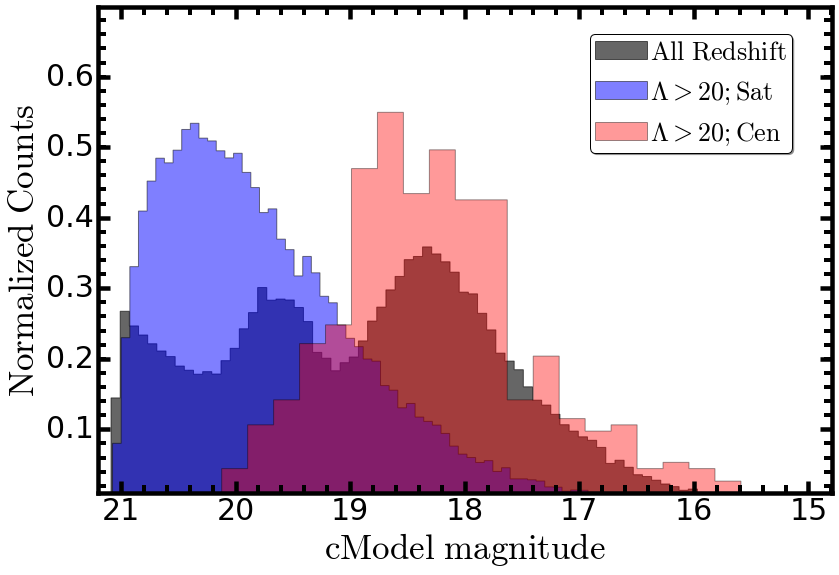

In [169]:
#---------------------------------------------------------#
fig = plt.figure(figsize=(12, 9))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
# Formatting 
ax1 = songPlotSetup(ax1)

# Vertical lines for sample selection 
ax1.axvline(0.2, linestyle='--', linewidth=4.5, c='k', alpha=0.3)
ax1.axvline(0.5, linestyle='--', linewidth=4.5, c='k', alpha=0.3)

# Histograms
temp = hist(nonbcgGood['imag_cmodel'] - nonbcgGood['a_i'], bins='knuth', histtype='stepfilled', 
            alpha=0.6, color='k', normed=True, label='$\mathrm{All\ Redshift}$')
temp = hist(redmemGood['imag_cmodel'] - redmemGood['a_i'], bins='knuth', histtype='stepfilled', 
            alpha=0.5, color='b', normed=True, label='$\Lambda>20; \mathrm{Sat}$')
temp = hist(redbcgGood['imag_cmodel'] - redbcgGood['a_i'], bins='knuth', histtype='stepfilled', 
            alpha=0.4, color='r', normed=True, label='$\Lambda>20; \mathrm{Cen}$')

# X, Y limits
ax1.set_xlim(21.2, 14.79)
ax1.set_ylim(0.010, 0.699)

# X, Y Label
ax1.set_xlabel('$\mathrm{cModel\ magnitude}$', fontsize=35)
ax1.set_ylabel('$\mathrm{Normalized\ Counts}$', fontsize=35)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.67, 0.70),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=26, scatterpoints=1, 
           markerscale=1.8, borderpad=0.2, handletextpad=0.1)

# Save
fig.savefig('figure/massive_s15b_icmodel_hist.png', dpi=200)

### Redshift range 

* 0.1999 < z_use < 0.520

In [215]:
redbcgIY = (redbcgGood['imag_cmodel'] - redbcgGood['a_i'] - 
            redbcgGood['ymag_cmodel'] + redbcgGood['a_y'])
redbcgUse = redbcgGood[(redbcgGood['z_use'] >= 0.1999) &
                       (redbcgGood['z_use'] <= 0.5010) & 
                       (redbcgGood['lambda_redm'] - redbcgGood['lambda_err_redm'] >= 18.0) &
                       (redbcgGood['p_cen_1_redm'] >= 0.55) & 
                       (redbcgIY > 0.10) & (redbcgIY <= 0.86)]
print("# %d / %d left in the sample" % (len(redbcgUse), len(redbcgGood)))

# 375 / 498 left in the sample


In [216]:
redmemIY = (redmemGood['imag_cmodel'] - redmemGood['a_i'] - 
            redmemGood['ymag_cmodel'] + redmemGood['a_y'])
redmemUse = redmemGood[(redmemGood['z_use'] >= 0.1999) &
                       (redmemGood['z_use'] <= 0.5101) & 
                       (redmemGood['lambda_redm'] - redmemGood['lambda_err_redm'] >= 18.0) &
                       (redmemGood['p_mem_redm'] >= 0.80) & 
                       (redmemGood['imag_cmodel'] - redmemGood['a_i'] <= 20.2) &
                       (redmemIY > 0.10) & (redmemIY <= 0.86)]
print("# %d / %d left in the sample" % (len(redmemUse), len(redmemGood)))

# 4250 / 30264 left in the sample


In [217]:
nonbcgIY = (nonbcgGood['imag_cmodel'] - nonbcgGood['a_i'] - 
            nonbcgGood['ymag_cmodel'] + nonbcgGood['a_y'])
nonbcgUse = nonbcgGood[(nonbcgGood['z_use'] >= 0.1999) &
                       (nonbcgGood['z_use'] <= 0.5101) & 
                       (nonbcgGood['imag_cmodel'] - nonbcgGood['a_i'] <= 20.2) &
                       (nonbcgIY > 0.10) & (nonbcgIY <= 0.86)]
print("# %d / %d left in the sample" % (len(nonbcgUse), len(nonbcgGood)))

# 29973 / 86619 left in the sample


### Add index and ID string

In [218]:
redbcgUse.add_column(Column(np.arange(len(redbcgUse)) + 1, name='index'))
redmemUse.add_column(Column(np.arange(len(redmemUse)) + 1, name='index'))
nonbcgUse.add_column(Column(np.arange(len(nonbcgUse)) + 1, name='index'))

In [222]:
redbcgUse.add_column(Column(np.asarray(['redbcg_' + str(i).strip() 
                                        for i in redbcgUse['index']]), 
                            name='id_use'))
redmemUse.add_column(Column(np.asarray(['redmem_' + str(i).strip() 
                                        for i in redmemUse['index']]), 
                            name='id_use'))
nonbcgUse.add_column(Column(np.asarray(['nonbcg_' + str(i).strip() 
                                        for i in nonbcgUse['index']]), 
                            name='id_use'))

### Add Maggies and IvarMaggies, and save the catalogs

In [223]:
redbcgNew = os.path.join(masterDir, 'dr1_redbcg_use.fits')
redmemNew = os.path.join(masterDir, 'dr1_redmem_use.fits')
nonbcgNew = os.path.join(masterDir, 'dr1_nonbcg_use.fits')

# Save the catalogs
redbcgUse.write(redbcgNew, format='fits', overwrite=True)
redmemUse.write(redmemNew, format='fits', overwrite=True)
nonbcgUse.write(nonbcgNew, format='fits', overwrite=True)

In [224]:
# Add maggies, and save catalogs for SED fitting (All 5 bands)
redbcgSed = os.path.join(masterDir, 'dr1_redbcg_use_sed5b.fits')
redmemSed = os.path.join(masterDir, 'dr1_redmem_use_sed5b.fits')
nonbcgSed = os.path.join(masterDir, 'dr1_nonbcg_use_sed5b.fits')

redbcgMag5 = addMaggies(redbcgNew, sortCol='z_use', filters=hscFilters, 
                        snr=100.0, outputCat=redbcgSed)
redmemMag5 = addMaggies(redmemNew, sortCol='z_use', filters=hscFilters, 
                        snr=100.0, outputCat=redmemSed)
nonbcgMag5 = addMaggies(nonbcgNew, sortCol='z_use', filters=hscFilters, 
                       snr=100.0, outputCat=nonbcgSed)

# Add maggies, and save catalogs for SED fitting (All 5 bands)
redbcgSed4 = os.path.join(masterDir, 'dr1_redbcg_use_sed4b.fits')
redmemSed4 = os.path.join(masterDir, 'dr1_redmem_use_sed4b.fits')
nonbcgSed4 = os.path.join(masterDir, 'dr1_nonbcg_use_sed4b.fits')

hscFilter4 = ['g', 'r', 'i', 'z']
redbcgMag4 = addMaggies(redbcgNew, sortCol='z_use', filters=hscFilter4, 
                        snr=100.0, outputCat=redbcgSed4)
redmemMag4 = addMaggies(redmemNew, sortCol='z_use', filters=hscFilter4, 
                        snr=100.0, outputCat=redmemSed4)
nonbcgMag4 = addMaggies(nonbcgNew, sortCol='z_use', filters=hscFilter4, 
                        snr=100.0, outputCat=nonbcgSed4)

### Exam the i-Y color

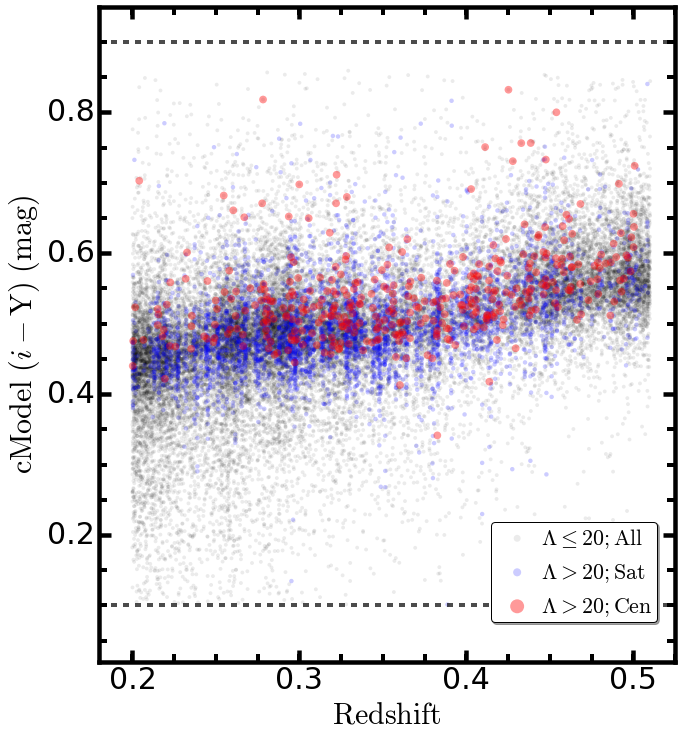

In [200]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.10, right=0.90, 
                    bottom=0.08, top=0.99,
                    wspace=0.02, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1)

# Color limtis 
ax1.axhline(0.90, linestyle='--', linewidth=4.0, alpha=0.7, color='k')
ax1.axhline(0.10, linestyle='--', linewidth=4.0, alpha=0.7, color='k')

# Scatter plots
simpleScatter(nonbcgUse['z_use'], 
              (nonbcgUse['imag_cmodel'] - nonbcgUse['a_i'] - 
               nonbcgUse['ymag_cmodel'] + nonbcgUse['a_y']), 
              ax=ax1, alpha=0.08, colorUse='k', sizeUse=15.0,
              xtick=0.1, label='$\Lambda\leq 20; \mathrm{All}$')
simpleScatter(redmemUse['z_use'], 
              (redmemUse['imag_cmodel'] - redmemUse['a_i'] - 
               redmemUse['ymag_cmodel'] + redmemUse['a_y']), 
              ax=ax1, alpha=0.20, colorUse='b', sizeUse=20.0,
              label='$\Lambda>20; \mathrm{Sat}$')
simpleScatter(redbcgUse['z_use'], 
              (redbcgUse['imag_cmodel'] - redbcgUse['a_i'] - 
               redbcgUse['ymag_cmodel'] + redbcgUse['a_y']), 
              ax=ax1, alpha=0.40, colorUse='r', sizeUse=60.0,
              label='$\Lambda>20; \mathrm{Cen}$')

# X, Y-label
ax1.set_xlabel('$\mathrm{Redshift}$', fontsize=30)
ax1.set_ylabel('$\mathrm{cModel}\ (i-\mathrm{Y})\ (\mathrm{mag})$', fontsize=30)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.025))

# X, Y-limit 
ax1.set_xlim(0.18, 0.525)
ax1.set_ylim(0.02, 0.95)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.68, 0.06),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=22, scatterpoints=1, 
           markerscale=1.8, borderpad=0.2, handletextpad=0.1)

fig.savefig('figure/massive_s15b_zuse_iycolor.png', dpi=200)

### Plot the redshift distributions

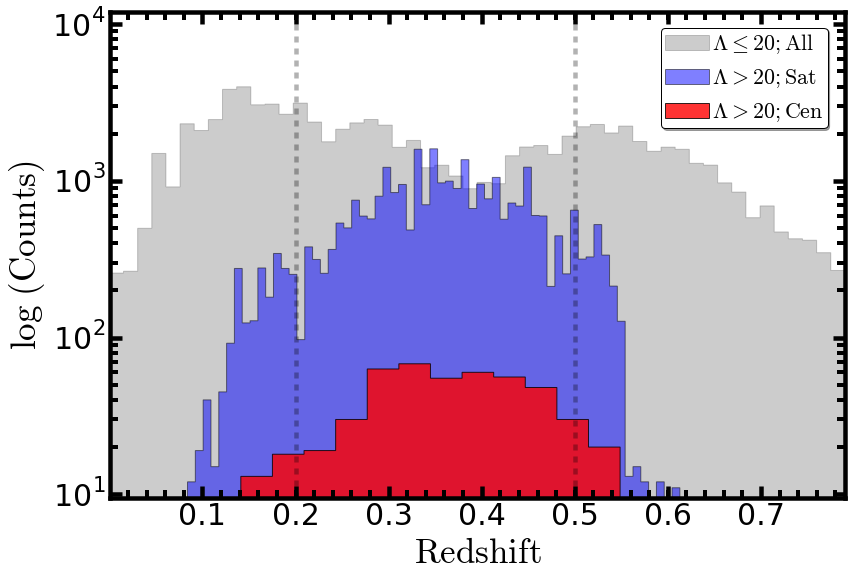

In [201]:
#---------------------------------------------------------#
fig = plt.figure(figsize=(12, 9))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
# Formatting 
ax1 = songPlotSetup(ax1)

# Vertical lines for sample selection 
ax1.axvline(0.2, linestyle='--', linewidth=4.5, c='k', alpha=0.3)
ax1.axvline(0.5, linestyle='--', linewidth=4.5, c='k', alpha=0.3)

# Histograms
temp = hist(nonbcgGood['z_use'], bins='knuth', histtype='stepfilled', 
            alpha=0.2, color='k', normed=False, 
            label='$\Lambda\leq 20; \mathrm{All}$')
temp = hist(redmemGood['z_use'], bins='knuth', histtype='stepfilled', 
            alpha=0.5, color='b', normed=False, 
            label='$\Lambda>20; \mathrm{Sat}$')
temp = hist(redbcgGood['z_use'], bins='knuth', histtype='stepfilled', 
            alpha=0.8, color='r', normed=False, 
            label='$\Lambda>20; \mathrm{Cen}$')

# X, Y limits
ax1.set_xlim(0.001, 0.79)
ax1.set_ylim(9.49, 11990.0)

# X, Y Label
ax1.set_xlabel('$\mathrm{Redshift}$', fontsize=35)
ax1.set_ylabel('$\log\ (\mathrm{Counts})$', fontsize=35)

# LogY axis
ax1.set_yscale('log')

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.75, 0.76),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=22, scatterpoints=1, 
           markerscale=1.8, borderpad=0.2, handletextpad=0.1)

fig.savefig('figure/massive_s15b_zuse_hist1.png', dpi=200)

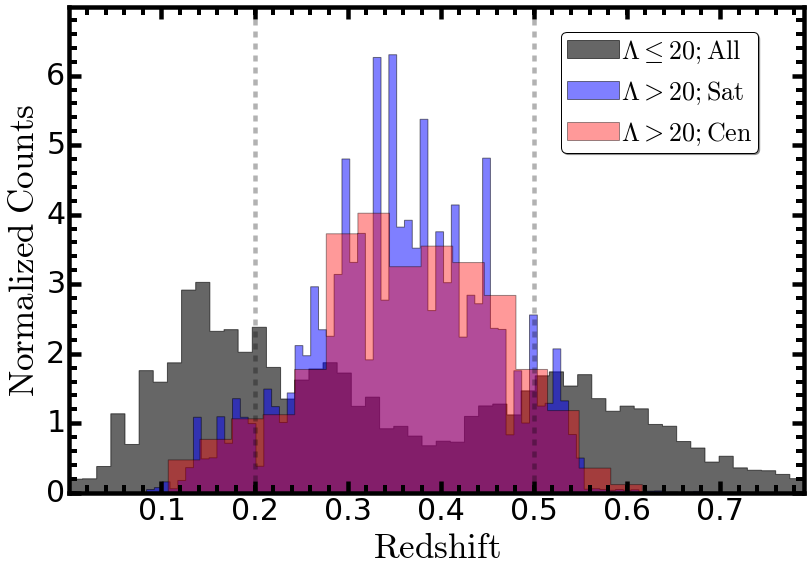

In [228]:
#---------------------------------------------------------#
fig = plt.figure(figsize=(12, 9))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
# Formatting 
ax1 = songPlotSetup(ax1)

# Vertical lines for sample selection 
ax1.axvline(0.2, linestyle='--', linewidth=4.5, c='k', alpha=0.3)
ax1.axvline(0.5, linestyle='--', linewidth=4.5, c='k', alpha=0.3)

# Histograms
temp = hist(nonbcgGood['z_use'], bins='knuth', histtype='stepfilled', 
            alpha=0.6, color='k', normed=True, label='$\Lambda\leq 20; \mathrm{All}$')
temp = hist(redmemGood['z_use'], bins='knuth', histtype='stepfilled', 
            alpha=0.5, color='b', normed=True, label='$\Lambda>20; \mathrm{Sat}$')
temp = hist(redbcgGood['z_use'], bins='knuth', histtype='stepfilled', 
            alpha=0.4, color='r', normed=True, label='$\Lambda>20; \mathrm{Cen}$')

# X, Y limits
ax1.set_xlim(0.001, 0.79)
ax1.set_ylim(0.000, 6.99)

# X, Y Label
ax1.set_xlabel('$\mathrm{Redshift}$', fontsize=35)
ax1.set_ylabel('$\mathrm{Normalized\ Counts}$', fontsize=35)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.67, 0.70),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=26, scatterpoints=1, 
           markerscale=1.8, borderpad=0.2, handletextpad=0.1)

fig.savefig('figure/massive_s15b_zuse_hist2.png', dpi=200)

# Show the RA, DEC distributions of potential galaxies

### G09: GAMA09

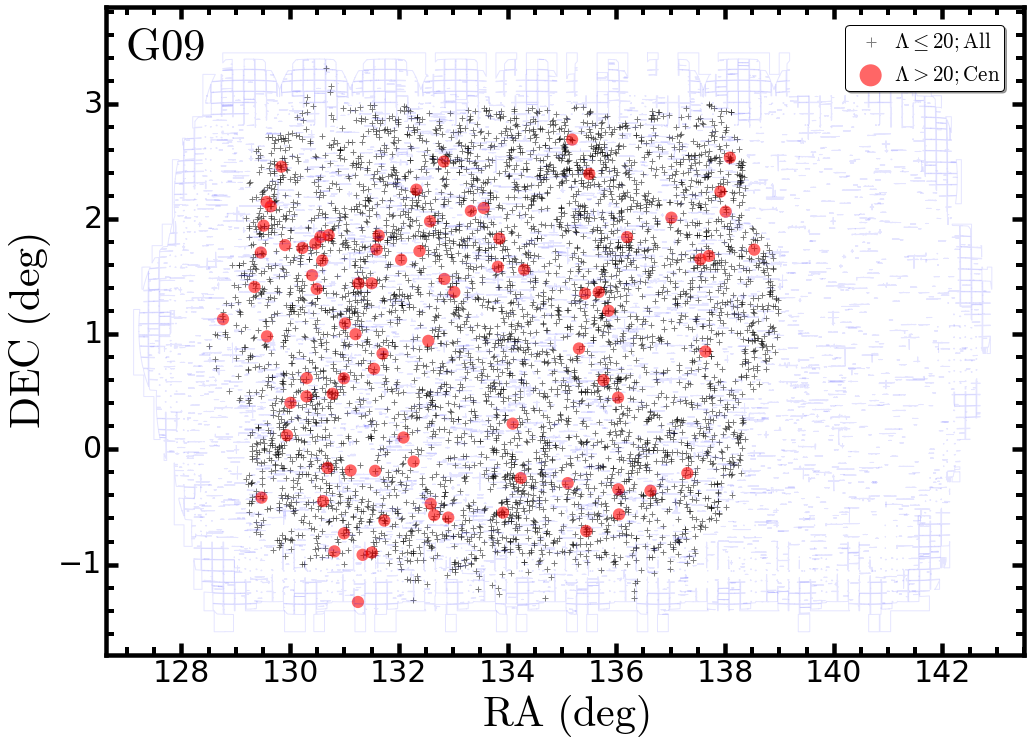

In [246]:
raCol, decCol = 'ra_hsc', 'dec_hsc'

# Acceptance Mask in five bands
acpStr = acpFormat.replace('FILTER', 'I')
acpStr = acpStr.replace('REG', 'g09')
acpFile = os.path.join(polyDir, acpStr)
acpMask = polyReadWkb(acpFile)
acpPrep = prep(acpMask)

"""
acp2 = acpFormat.replace('FILTER', 'G')
acp2 = acp2.replace('REG', 'g09')
acpFile2 = os.path.join(polyDir, acp2)
acpMask2 = polyReadWkb(acpFile2)

acp3 = acpFormat.replace('FILTER', 'Z')
acp3 = acp2.replace('REG', 'g09')
acpFile3 = os.path.join(polyDir, acp3)
acpMask3 = polyReadWkb(acpFile3)

acpAll = copy.deepcopy(acpMask)
acpAll = acpAll.intersection(acpMask2)
acpAll = acpAll.intersection(acpMask3)
"""

# Rejection mask in I bands 
rejStr = rejFormat.replace('FILTER', 'I')
rejStr = rejStr.replace('REG', 'g09')
rejFile = os.path.join(polyDir, rejStr)
rejMask = polyReadWkb(rejFile)
rejPrep = prep(rejMask)

#inside = map(lambda x, y: acpPrep.contains(Point(x, y)), raArr, decArr)
#masked = map(lambda x, y: rejPrep.contains(Point(x, y)), raArr, decArr)
#useful = map(lambda x, y: x and (not y), inside, masked)

#---------------------------------------------------------#
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

# Formatting 
ax1 = songPlotSetup(ax1)

# RedMapper 
ax1.scatter(nonbcgUse[raCol], nonbcgUse[decCol], c='k', s=30, 
            alpha=0.5, marker='+', label='$\Lambda\leq 20; \mathrm{All}$')
#ax1.scatter(redmemUse[raCol], redmemUse[decCol], c='b', s=50, 
#            alpha=0.5, marker='s', edgecolor='none', 
#            label='$\Lambda>20; \mathrm{Sat}$')
ax1.scatter(redbcgUse[raCol], redbcgUse[decCol], c='r', s=150, 
            alpha=0.6, marker='o', edgecolor='none',
            label='$\Lambda>20; \mathrm{Cen}$')

# Boundary 
#showPolyMask(acpMask, ax1, alpha=0.8, lw=3.0, color='k')
showPolyMask(rejMask, ax1, alpha=0.1, lw=1.0, color='b')

# Label
ax1.set_xlabel('$\mathrm{RA\ (deg)}$',  size=42)
ax1.set_ylabel('$\mathrm{DEC\ (deg)}$', size=42)

# Axis limits
ax1.set_xlim(acpMask.bounds[0]-0.5, acpMask.bounds[2]+0.6)
ax1.set_ylim(acpMask.bounds[1]-0.2, acpMask.bounds[3]+0.4)

# Title 
ax1.text(0.02, 0.92, '$\mathrm{G09}$', size=45, 
         transform = ax1.transAxes)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.805, 0.870),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=21, scatterpoints=1, 
           markerscale=1.8, borderpad=0.2, handletextpad=0.1)

fig.savefig('figure/massive_s15b_g09_sample.png', dpi=200)

### G15: GAMA15

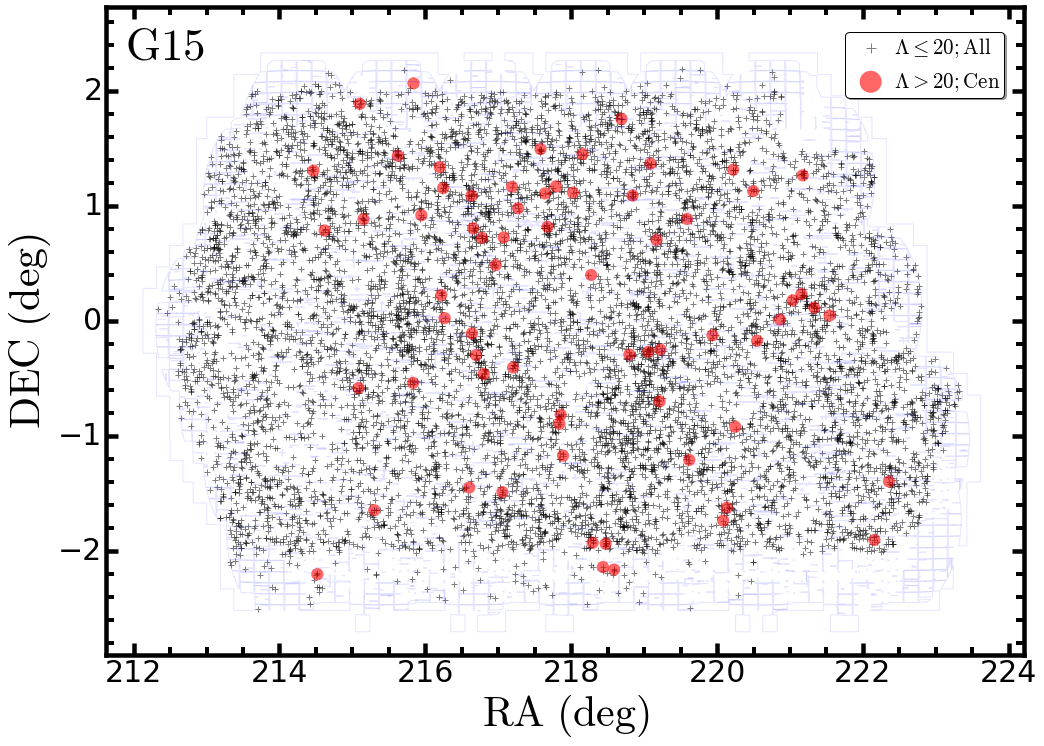

In [249]:
# Acceptance Mask in five bands
acpStr = acpFormat.replace('FILTER', 'I')
acpStr = acpStr.replace('REG', 'g15')
acpFile = os.path.join(polyDir, acpStr)
acpMask = polyReadWkb(acpFile)
acpPrep = prep(acpMask)

# Rejection mask in I bands 
rejStr = rejFormat.replace('FILTER', 'I')
rejStr = rejStr.replace('REG', 'g15')
rejFile = os.path.join(polyDir, rejStr)
rejMask = polyReadWkb(rejFile)
rejPrep = prep(rejMask)

#---------------------------------------------------------#
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

# Formatting 
ax1 = songPlotSetup(ax1)

# RedMapper 
ax1.scatter(nonbcgUse[raCol], nonbcgUse[decCol], c='k', s=30, 
            alpha=0.5, marker='+', label='$\Lambda\leq 20; \mathrm{All}$')
#ax1.scatter(redmemUse[raCol], redmemUse[decCol], c='b', s=50, 
#            alpha=0.5, marker='s', edgecolor='none', 
#            label='$\Lambda>20; \mathrm{Sat}$')
ax1.scatter(redbcgUse[raCol], redbcgUse[decCol], c='r', s=150, 
            alpha=0.6, marker='o', edgecolor='none',
            label='$\Lambda>20; \mathrm{Cen}$')

# Boundary 
#showPolyMask(acpMask, ax1, alpha=0.8, lw=3.0, color='k')
showPolyMask(rejMask, ax1, alpha=0.1, lw=1.0, color='b')

# Label
ax1.set_xlabel('$\mathrm{RA\ (deg)}$',  size=42)
ax1.set_ylabel('$\mathrm{DEC\ (deg)}$', size=42)

# Axis limits
ax1.set_xlim(rejMask.bounds[0]-0.5, rejMask.bounds[2]+0.6)
ax1.set_ylim(rejMask.bounds[1]-0.2, rejMask.bounds[3]+0.4)

# Title 
ax1.text(0.02, 0.92, '$\mathrm{G15}$', size=45, 
         transform = ax1.transAxes)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.805, 0.860),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=21, scatterpoints=1, 
           markerscale=1.8, borderpad=0.2, handletextpad=0.1)

fig.savefig('figure/massive_s15b_g15_sample.png', dpi=200)

### W12: GAMA12

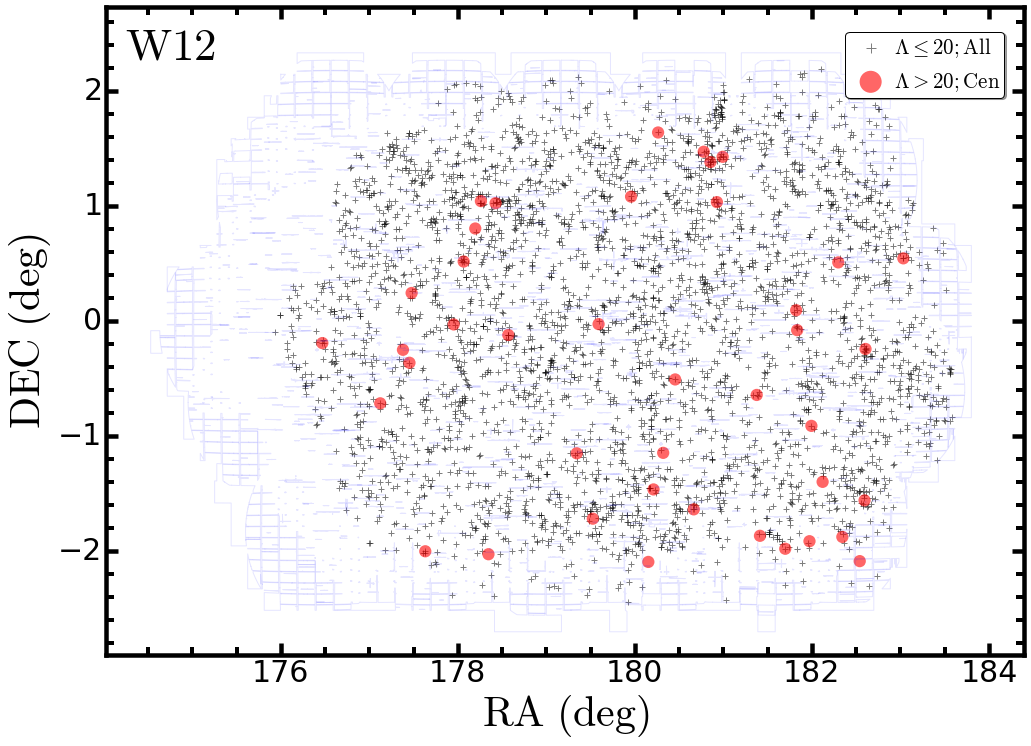

In [250]:
# Acceptance Mask in five bands
acpStr = acpFormat.replace('FILTER', 'I')
acpStr = acpStr.replace('REG', 'w12')
acpFile = os.path.join(polyDir, acpStr)
acpMask = polyReadWkb(acpFile)
acpPrep = prep(acpMask)

# Rejection mask in I bands 
rejStr = rejFormat.replace('FILTER', 'I')
rejStr = rejStr.replace('REG', 'w12')
rejFile = os.path.join(polyDir, rejStr)
rejMask = polyReadWkb(rejFile)
rejPrep = prep(rejMask)

#---------------------------------------------------------#
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

# Formatting 
ax1 = songPlotSetup(ax1)

# RedMapper 
ax1.scatter(nonbcgUse[raCol], nonbcgUse[decCol], c='k', s=30, 
            alpha=0.5, marker='+', label='$\Lambda\leq 20; \mathrm{All}$')
#ax1.scatter(redmemUse[raCol], redmemUse[decCol], c='b', s=50, 
#            alpha=0.5, marker='s', edgecolor='none', 
#            label='$\Lambda>20; \mathrm{Sat}$')
ax1.scatter(redbcgUse[raCol], redbcgUse[decCol], c='r', s=150, 
            alpha=0.6, marker='o', edgecolor='none',
            label='$\Lambda>20; \mathrm{Cen}$')

# Boundary 
#showPolyMask(acpMask, ax1, alpha=0.8, lw=3.0, color='k')
showPolyMask(rejMask, ax1, alpha=0.1, lw=1.0, color='b')

# Label
ax1.set_xlabel('$\mathrm{RA\ (deg)}$',  size=42)
ax1.set_ylabel('$\mathrm{DEC\ (deg)}$', size=42)

# Axis limits
ax1.set_xlim(rejMask.bounds[0]-0.5, rejMask.bounds[2]+0.6)
ax1.set_ylim(rejMask.bounds[1]-0.2, rejMask.bounds[3]+0.4)

# Title 
ax1.text(0.02, 0.92, '$\mathrm{W12}$', size=45, 
         transform = ax1.transAxes)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.805, 0.860),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=21, scatterpoints=1, 
           markerscale=1.8, borderpad=0.2, handletextpad=0.1)

fig.savefig('figure/massive_s15b_w12_sample.png', dpi=200)

### VVD: VVDS

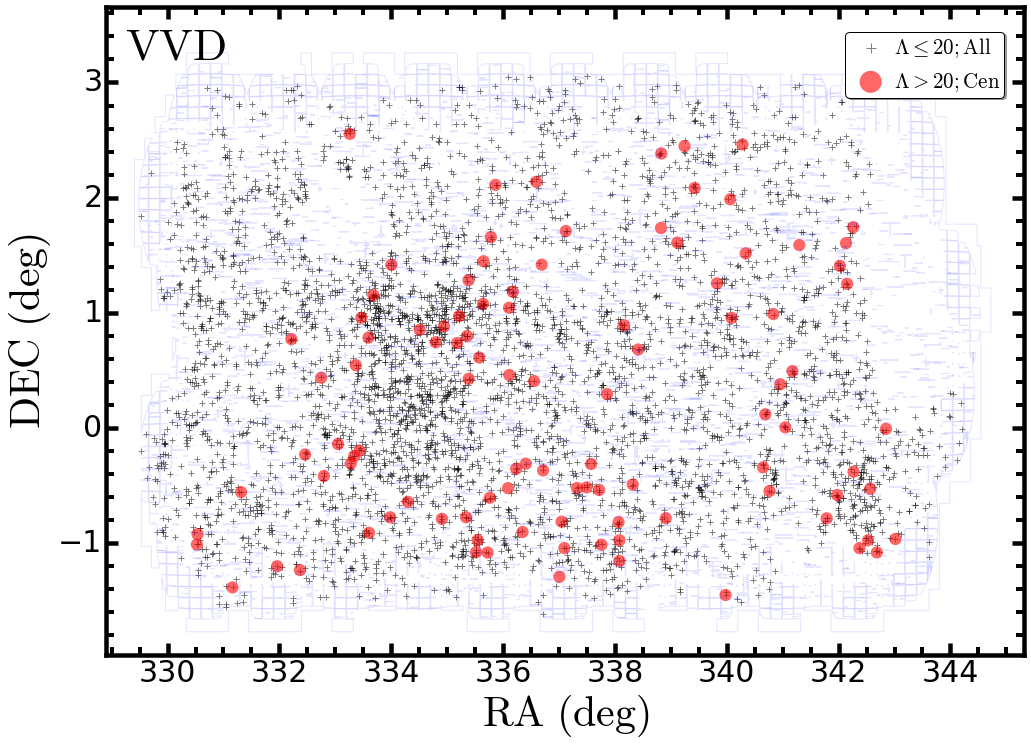

In [251]:
# Acceptance Mask in five bands
acpStr = acpFormat.replace('FILTER', 'I')
acpStr = acpStr.replace('REG', 'vvd')
acpFile = os.path.join(polyDir, acpStr)
acpMask = polyReadWkb(acpFile)
acpPrep = prep(acpMask)

# Rejection mask in I bands 
rejStr = rejFormat.replace('FILTER', 'I')
rejStr = rejStr.replace('REG', 'vvd')
rejFile = os.path.join(polyDir, rejStr)
rejMask = polyReadWkb(rejFile)
rejPrep = prep(rejMask)

#---------------------------------------------------------#
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

# Formatting 
ax1 = songPlotSetup(ax1)

# RedMapper 
ax1.scatter(nonbcgUse[raCol], nonbcgUse[decCol], c='k', s=30, 
            alpha=0.5, marker='+', label='$\Lambda\leq 20; \mathrm{All}$')
#ax1.scatter(redmemUse[raCol], redmemUse[decCol], c='b', s=50, 
#            alpha=0.5, marker='s', edgecolor='none', 
#            label='$\Lambda>20; \mathrm{Sat}$')
ax1.scatter(redbcgUse[raCol], redbcgUse[decCol], c='r', s=150, 
            alpha=0.6, marker='o', edgecolor='none',
            label='$\Lambda>20; \mathrm{Cen}$')

# Boundary 
#showPolyMask(acpMask, ax1, alpha=0.8, lw=3.0, color='k')
showPolyMask(rejMask, ax1, alpha=0.1, lw=1.0, color='b')

# Label
ax1.set_xlabel('$\mathrm{RA\ (deg)}$',  size=42)
ax1.set_ylabel('$\mathrm{DEC\ (deg)}$', size=42)

# Axis limits
ax1.set_xlim(rejMask.bounds[0]-0.5, rejMask.bounds[2]+0.6)
ax1.set_ylim(rejMask.bounds[1]-0.2, rejMask.bounds[3]+0.4)

# Title 
ax1.text(0.02, 0.92, '$\mathrm{VVD}$', size=45, 
         transform = ax1.transAxes)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.805, 0.860),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=21, scatterpoints=1, 
           markerscale=1.8, borderpad=0.2, handletextpad=0.1)

fig.savefig('figure/massive_s15b_vvd_sample.png', dpi=200)

### XMM: XMM-LSS

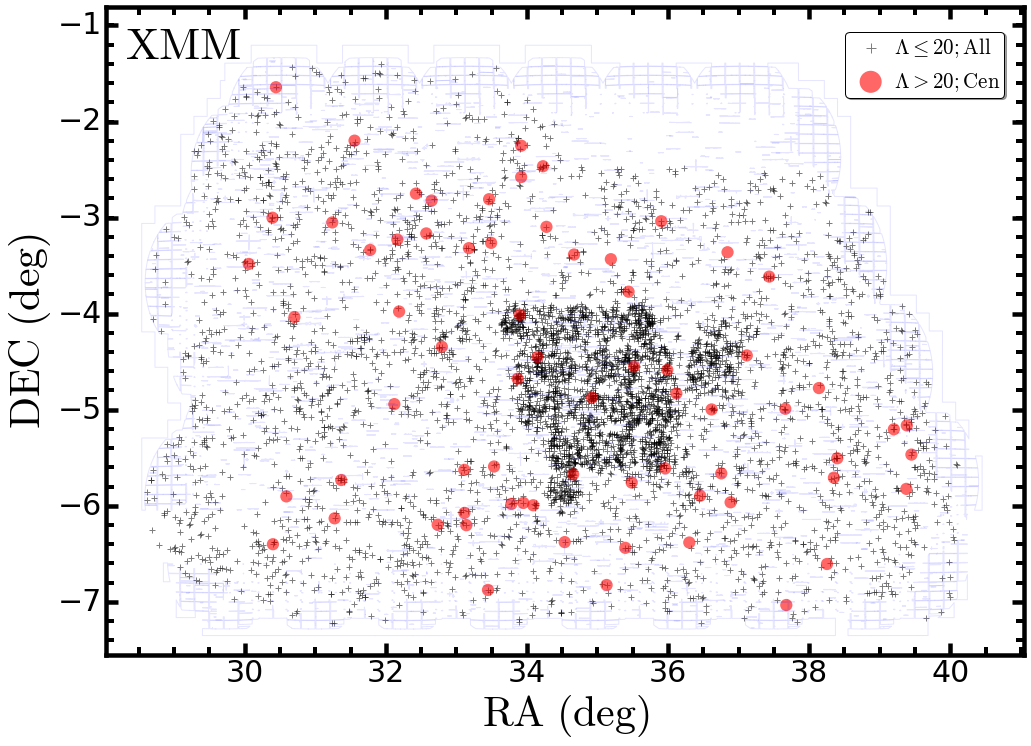

In [252]:
# Acceptance Mask in five bands
acpStr = acpFormat.replace('FILTER', 'I')
acpStr = acpStr.replace('REG', 'xmm')
acpFile = os.path.join(polyDir, acpStr)
acpMask = polyReadWkb(acpFile)
acpPrep = prep(acpMask)

# Rejection mask in I bands 
rejStr = rejFormat.replace('FILTER', 'I')
rejStr = rejStr.replace('REG', 'xmm')
rejFile = os.path.join(polyDir, rejStr)
rejMask = polyReadWkb(rejFile)
rejPrep = prep(rejMask)

#---------------------------------------------------------#
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

# Formatting 
ax1 = songPlotSetup(ax1)

# RedMapper 
ax1.scatter(nonbcgUse[raCol], nonbcgUse[decCol], c='k', s=30, 
            alpha=0.5, marker='+', label='$\Lambda\leq 20; \mathrm{All}$')
#ax1.scatter(redmemUse[raCol], redmemUse[decCol], c='b', s=50, 
#            alpha=0.5, marker='s', edgecolor='none', 
#            label='$\Lambda>20; \mathrm{Sat}$')
ax1.scatter(redbcgUse[raCol], redbcgUse[decCol], c='r', s=150, 
            alpha=0.6, marker='o', edgecolor='none',
            label='$\Lambda>20; \mathrm{Cen}$')

# Boundary 
#showPolyMask(acpMask, ax1, alpha=0.8, lw=3.0, color='k')
showPolyMask(rejMask, ax1, alpha=0.1, lw=1.0, color='b')

# Label
ax1.set_xlabel('$\mathrm{RA\ (deg)}$',  size=42)
ax1.set_ylabel('$\mathrm{DEC\ (deg)}$', size=42)

# Axis limits
ax1.set_xlim(rejMask.bounds[0]-0.5, rejMask.bounds[2]+0.6)
ax1.set_ylim(rejMask.bounds[1]-0.2, rejMask.bounds[3]+0.4)

# Title 
ax1.text(0.02, 0.92, '$\mathrm{XMM}$', size=45, 
         transform = ax1.transAxes)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.805, 0.860),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=21, scatterpoints=1, 
           markerscale=1.8, borderpad=0.2, handletextpad=0.1)

fig.savefig('figure/massive_s15b_xmm_sample.png', dpi=200)

### HEC: HectoMap

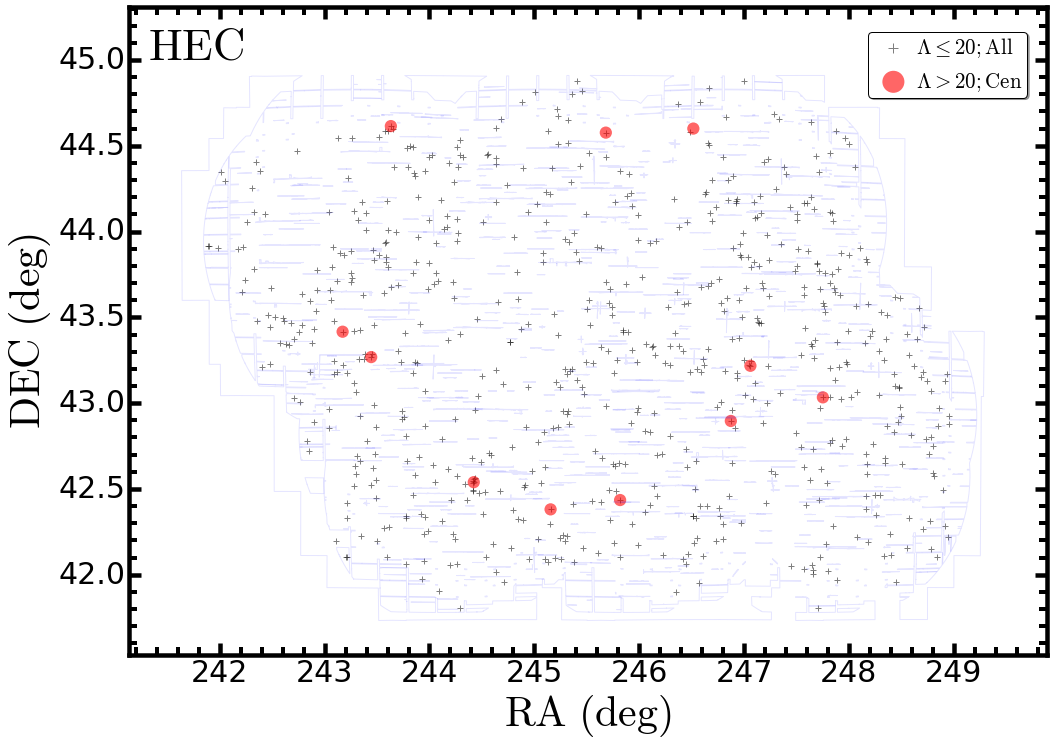

In [253]:
# Acceptance Mask in five bands
acpStr = acpFormat.replace('FILTER', 'I')
acpStr = acpStr.replace('REG', 'hec')
acpFile = os.path.join(polyDir, acpStr)
acpMask = polyReadWkb(acpFile)
acpPrep = prep(acpMask)

# Rejection mask in I bands 
rejStr = rejFormat.replace('FILTER', 'I')
rejStr = rejStr.replace('REG', 'hec')
rejFile = os.path.join(polyDir, rejStr)
rejMask = polyReadWkb(rejFile)
rejPrep = prep(rejMask)

#---------------------------------------------------------#
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

# Formatting 
ax1 = songPlotSetup(ax1)

# RedMapper 
ax1.scatter(nonbcgUse[raCol], nonbcgUse[decCol], c='k', s=30, 
            alpha=0.5, marker='+', label='$\Lambda\leq 20; \mathrm{All}$')
#ax1.scatter(redmemUse[raCol], redmemUse[decCol], c='b', s=50, 
#            alpha=0.5, marker='s', edgecolor='none', 
#            label='$\Lambda>20; \mathrm{Sat}$')
ax1.scatter(redbcgUse[raCol], redbcgUse[decCol], c='r', s=150, 
            alpha=0.6, marker='o', edgecolor='none',
            label='$\Lambda>20; \mathrm{Cen}$')

# Boundary 
#showPolyMask(acpMask, ax1, alpha=0.8, lw=3.0, color='k')
showPolyMask(rejMask, ax1, alpha=0.1, lw=1.0, color='b')

# Label
ax1.set_xlabel('$\mathrm{RA\ (deg)}$',  size=42)
ax1.set_ylabel('$\mathrm{DEC\ (deg)}$', size=42)

# Axis limits
ax1.set_xlim(rejMask.bounds[0]-0.5, rejMask.bounds[2]+0.6)
ax1.set_ylim(rejMask.bounds[1]-0.2, rejMask.bounds[3]+0.4)

# Title 
ax1.text(0.02, 0.92, '$\mathrm{HEC}$', size=45, 
         transform = ax1.transAxes)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.805, 0.860),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=21, scatterpoints=1, 
           markerscale=1.8, borderpad=0.2, handletextpad=0.1)

fig.savefig('figure/massive_s15b_hec_sample.png', dpi=200)